[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)

# based on Fig 2. in [Fisher 1991](https://doi.org/10.3402/tellusb.v43i5.15414) "_Remarks on the deuterium excess in precipitation in cold regions_"



In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot
from scipy.integrate import solve_ivp
from functools import partial

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics.constants import PER_MILLE, in_unit
from PySDM_examples.Jouzel_and_Merlivat_1984.thermodynamic_profiles import (
    vapour_mixing_ratio,
    ice_saturation_curve_4
)

In [3]:
formulae= Formulae(
    isotope_meteoric_water_line="Dansgaard1964",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_kinetic_fractionation_factors="JouzelAndMerlivat1984",
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970",
)
const = formulae.constants
K2C = formulae.trivia.K2C

diffusivity_ratio = {}
alpha_eq = {}
alpha_kinetic = {}
isotopes = ("2H", "18O")
for isotope in isotopes:
    alpha_eq[isotope] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_i_{isotope}')
    diffusivity_ratio[isotope] = getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}_heavy_to_light')

In [4]:
def alpha_kin(iso, T):
    return formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium = alpha_eq[iso](T),
        diffusivity_ratio_heavy_to_light=diffusivity_ratio[iso](T),
        saturation_over_ice = ice_saturation_curve_4(const=const, T=T)
    )

In [5]:
def d_delta_dT(T, delta):
    y = yf(T=T)
    dT = 1 * si.K
    dy_dT = (yf(T=T + dT) - y) / dT
    res = [0, 0]
    for i, iso in enumerate(isotopes):
        alpha = alpha_eq[iso](T) * alpha_kin(iso, T)
        alpha_dT = alpha_eq[iso](T+dT) * alpha_kin(iso, T+dT)
        d_alpha_dT = (alpha_dT - alpha) / dT
        res[i] = (
            (1 + delta[i])
            * (alpha * (alpha - 1) * dy_dT + y * d_alpha_dT)
            / (alpha * (y + alpha * y_e))
        )
    return res

In [6]:
delta_18O_0 = -15 * PER_MILLE
delta_2H_0 = const.CRAIG_1961_SLOPE_COEFF * delta_18O_0
temperature = np.linspace(260, 225, 10) * si.K

y_e = 0
yf = partial(vapour_mixing_ratio, formulae)


In [7]:
result = solve_ivp(
    fun=d_delta_dT,
    t_span=(temperature[0], temperature[-1]),
    y0=[delta_2H_0, delta_18O_0],
    t_eval=temperature
)
assert result.success, result.message
delta_2H, delta_18O = result.y
d_excess = formulae.isotope_meteoric_water_line.excess_d(
    delta_2H=delta_2H,
    delta_18O=delta_18O
)

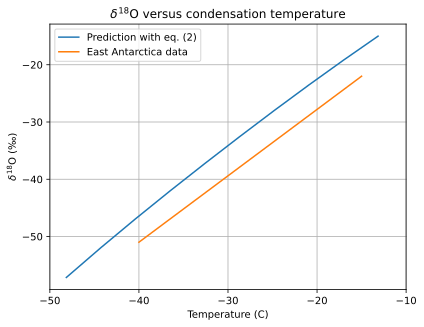

In [8]:
T_ticks = (-50, -40, -30, -20, -10)
n_points = 9
delta_18O_from_fig1 = np.linspace(-51, -22, n_points) * PER_MILLE
T_from_fig1 = np.linspace(-40, -15, n_points)


pyplot.plot(
    K2C(temperature[::-1]),
    in_unit(delta_18O[::-1], PER_MILLE),
    label="Prediction with eq. (2)",
)

pyplot.plot(
    T_from_fig1, in_unit(delta_18O_from_fig1, PER_MILLE), label="East Antarctica data"
)

pyplot.gca().set(
    title="$\\delta^{18}$O versus condensation temperature",
    xlabel="Temperature (C)",
    ylabel="$\\delta^{18}$O (‰)",
    xticks=T_ticks,
)
pyplot.grid()
pyplot.legend()
show_plot("fig_1")

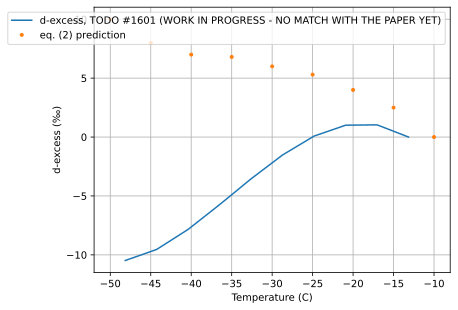

In [9]:
d_excess_from_fig2 = np.array((10, 8, 7, 6.8, 6, 5.3, 4, 2.5, 0)) * PER_MILLE
T_from_fig2 = np.linspace(-50, -10, n_points)


pyplot.plot(
    K2C(temperature[::-1]),
    in_unit(d_excess, PER_MILLE)[::-1],
    label="d-excess, TODO #1601 (WORK IN PROGRESS - NO MATCH WITH THE PAPER YET)",
)

pyplot.plot(
    T_from_fig2, in_unit(d_excess_from_fig2, PER_MILLE), ".", label="eq. (2) prediction"
)
pyplot.gca().set(xlabel="Temperature (C)", ylabel="d-excess (‰)")
pyplot.grid()
pyplot.legend()
show_plot("fig_2")